# Predict Telco Customer Churn
https://www.kaggle.com/blastchar/telco-customer-churn 

Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs."  

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents

References: https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

In [24]:
#!pip install lifelines

In [25]:
#!pip install seaborn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes   
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter


## Data read and clean

In [11]:
##  create a dataframe
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [14]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censored data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [16]:
#check for null
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [17]:
## Impute the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

In [18]:
## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

In [19]:
## lets have a look at the categories and their distribution in all the categorical columns.

for i in cat_cols:
    print('Column Name: ',i)
    print(df[i].value_counts())
    print('-----------------------------')

Column Name:  gender
Male      3555
Female    3488
Name: gender, dtype: int64
-----------------------------
Column Name:  Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
-----------------------------
Column Name:  Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
-----------------------------
Column Name:  PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
-----------------------------
Column Name:  MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
-----------------------------
Column Name:  InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
-----------------------------
Column Name:  OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
-----------------------------
Column Name:  OnlineBackup
No                     3088
Yes     

# Survival Analysis with Kaplan Meier (non-parametric)

Fundamental concepts of Survival Analysis 
 

1. Survival time: Referred to an amount of time until when a customer is alive (not churned) or actively participates in a survey. 
2. Event: In our context, we define event as 'churn'. 
3. Censoring of data: Survival analysis focuses on the occurrence of an event of interest (e.g., churn). But there is still a possibility that the event may not be observed for various reasons. Such observations are known as censored observations. Censoring may arise in the following ways:
    * Customer hasn't churned during the time-period.   
    * Customer has churned OR isn't tracked anymore (perhaps they fell out of the study) - also called RIGHT Censoring
    * Left-censoring: Churn could not be observed for some reason - perhaps a customer already had churned when the experiment started  
    * Interval censoring: Customer churuned during the experiment, but not sure when, as ddata available only for some intervals. We will try to avoid left and interval censored data. 

4. Survival and hazard functions: We generally use two related probabilities to analyse survival data.
    * The survival probability: We will use Survivor function S(t), which is the Kaplan-Meier Estimator. Survival probability is the probability that a customer survives (stays) from the time of origin (e.g. date joined) to a specified future time t. For example, S(200) = 0.7 means that after 200 days has passed since the customer had joined, the customer's survival probability has dropped to 0.7. If the customer stays alive at the end of an experiment, then that data will be censored.
    * The hazard probability: Denoted by h(t) - the probability that a customer, who is under observation at a time t has churned ('event') at that time. For example, If h(200) = 0.7, then it means that the probability of that customer having churned at time t=200 days is 0.7.

Note that, in contrast to the survivor function, which focuses on not having an event, the hazard function focuses on the event occurring. Higher survival probability and lower hazard probability is good for business.


Source: https://www.kdnuggets.com/2020/07/complete-guide-survival-analysis-python-part1.html


<AxesSubplot:xlabel='timeline'>

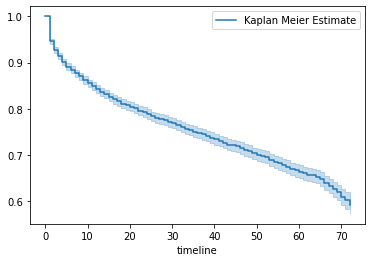

In [20]:
## Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

durations = df['tenure'] ## Time to event data of censored and event data
event_observed = df['Churn']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

How to read the above graph? At time t = 0, the survival probability of the entire cohort is 1. This is expected, as all in-scope customers are subscribed at the beginning of the study. At time t = 70 months, the survival proability drops to 0.6 . This means that at the end of 70 months, there is only a 60% chance that the a customer stays. 


How to read the Event table below? 

(1) Event_at: It stores the value of the timeline for our dataset, i.e., when was the customer observed in our experiment or when was the experiment conducted. It can be the number of minutes, days, months, years etc. In our case, it’s going to be the number of months. It basically stores the value of survival days for a customer.

(2) At_risk: It stores the number of current customers. At the start, it will be the total number of customers we are going to observe in our experiment. If at a certain time, new cutomers are added, then we have to increase it’s value accordingly. Basically, we can say that:

at_risk = current patients at_risk + entrance — removed

(3) Entrance: It stores the value of new customers in a given timeline. It’ possible that while we have other customers, some new customers also churned. That’s why we add it here.

(4) Censored: Our ultimate goal is to find the survival probability for a customer. If at a specific timeline customer under experiment is still alive, then that customer goes into the censored category. If we don’t have information about when a customer churned, then we add it to the censored data. Other possibilities are if a customer chooses drop out of study, we add that customer into the censored category.

(5) Observed: The number of customers that churned during the experiment.

(6) Removed: It stores the values of customers that are no longer part of our experiment. If a customer churned or is censored, then they fall into this category. In short,

Removed = Observed + Censored

In [23]:
km.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,11,0,11,7043,7043
1,613,380,233,0,7032
2,238,123,115,0,6419
3,200,94,106,0,6181
4,176,83,93,0,5981
...,...,...,...,...,...
68,100,9,91,0,846
69,95,8,87,0,746
70,119,11,108,0,651


## Kaplan Meier for cohorts

Calculate survival probability for each cohort and compare. Remember time is the same as tenure, and the event is the churn. The next section compares survival rate of each cohort created on the basis of contract term

<AxesSubplot:xlabel='timeline'>

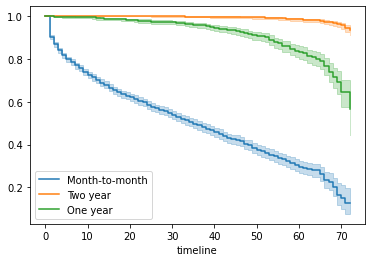

In [22]:
kmf = KaplanMeierFitter() 


T = df['tenure']     ## time to event
E = df['Churn']      ## event occurred or censored


groups = df['Contract']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'Month-to-month')   ## Cohort 1
ix2 = (groups == 'Two year')         ## Cohort 2
ix3 = (groups == 'One year')         ## Cohort 3


kmf.fit(T[ix1], E[ix1], label='Month-to-month')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Two year')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='One year')        ## fit the cohort 3 data
kmf.plot(ax=ax1)                                 ## Plot the KM curve for three cohort on same x and y axis

So, the customers having two-year contracts are most likely to stay. Customers month-to-month shows a drop show at the very begining - any way they can be reached in the initial stages to prevent them from leaving? 

<AxesSubplot:xlabel='timeline'>

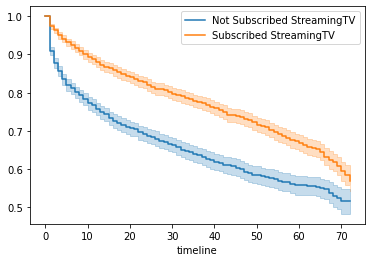

In [26]:

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = df['StreamingTV']   
i1 = (groups == 'No')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Yes')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1)

Another cohort comparison above